In [1]:
# Disable TensorFlow debugging info and warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 2: Info and warnings not displayed 

In [2]:
import numpy as np
import sklearn.decomposition
import imblearn
import matplotlib.pyplot as plt
import matplotlib.colors
import pathlib
import tqdm
import annotation, misc, hyspec_cnn, hyspec_io, hyspec_ml  # Local imports

In [3]:
# Parameters
samples_frac = 0.05


In [4]:
# Paths
hyspec_base = pathlib.Path('/media/mha114/Massimal/Vega_Sola/Hyperspectral/20220823/Area/2a_Rrs')
train_val_base = pathlib.Path('/media/mha114/Massimal/Vega_Sola/Hyperspectral/20220823/Area/3a_PCA_TrainValidationSplit')
class_json = train_val_base / 'Training/Annotation/label_classes.json'
pca_dir = pathlib.Path('/media/mha114/Massimal/Vega_Sola/Hyperspectral/20220823/Area/M_PCAModel')
spectra_file = pca_dir / '20220823_Vega_Sola_ExtractedSpectraAndLabels2023-05-27-01h42m12s.npz'
pca_model_path = pca_dir / '20220823_Vega_Sola_PCA-Model.npz'
figures_dir = pathlib.Path('/home/mha114/Dropbox/UiT/Massimal/Konferanser/NORA2023/Images')

In [5]:
# Get wavelengths from example hyspec file
example_hyspec_file_path = [path for path in sorted(hyspec_base.rglob('*.hdr'))][0]
_,wl,_,_ = hyspec_io.load_envi_image(str(example_hyspec_file_path),rgb_only=True)

In [6]:
# Load data
with np.load(spectra_file) as npz_files:
    X_raw = npz_files['X']
    y_raw = npz_files['y']

In [7]:
# Load saved model
W_pca,X_mean_loaded,X_std_loaded = hyspec_ml.read_pca_model(pca_model_path)

In [8]:
# Remove zero-valued spectra (caused by saturation)
nonzero_spectra_mask = ~np.all(X_raw==0,axis=1)
X = X_raw[nonzero_spectra_mask,:]
y = y_raw[nonzero_spectra_mask]

In [9]:
# Load class names and indices
class_dict = annotation.read_hasty_metadata(class_json)

In [10]:
# Inspect number of samples per class
for class_name, class_index in class_dict.items():
    print(f'{class_name:35} {np.count_nonzero(y==class_index)} samples')

Rock                                205572 samples
Cobble                              106211 samples
Sand                                245730 samples
Mearl bed                           385290 samples
Rockweed                            139784 samples
Kelp                                69648 samples
Brown algae                         274157 samples


In [11]:
# Create custom colormap for classes (including background:0)
custom_cmap = matplotlib.colors.ListedColormap(colors=['black',           # Background
                                                       'hotpink',         # Rock
                                                       'royalblue',       # Cobble
                                                       'darkturquoise',            # Sand
                                                       'magenta',         # Maerl bed
                                                       'seagreen',        # Rockweed
                                                       'darkorange',      # Kelp
                                                       'brown'])          # Brown algae

In [12]:
# Undersample to balance dataset
rus = imblearn.under_sampling.RandomUnderSampler(random_state=0)
X_bal, y_bal = rus.fit_resample(X,y)

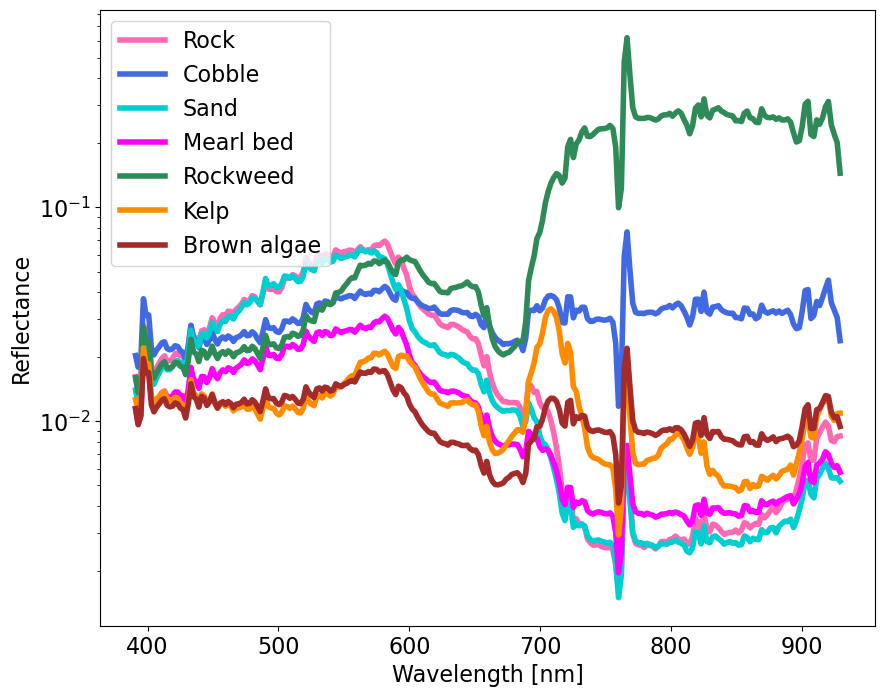

In [13]:
# Plot mean value for each class
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(10,8))
for ((class_name, class_index),plot_color) in zip(class_dict.items(),custom_cmap.colors[1:]):
    class_mean = np.mean(X_bal[y_bal==class_index],axis=0)
    plt.semilogy(wl,class_mean,label=class_name,linewidth=4,color=plot_color)
plt.legend()
plt.ylabel('Reflectance')
plt.xlabel('Wavelength [nm]')
plt.savefig(figures_dir / 'Vega_mean_spectra.png')
plt.show()

In [14]:
# Calculate mean and standard deviation, normalize spectra
X_mean = np.mean(X_bal,axis=0)
X_std = np.std(X_bal,axis=0)
X_norm = (X_bal - X_mean) / X_std

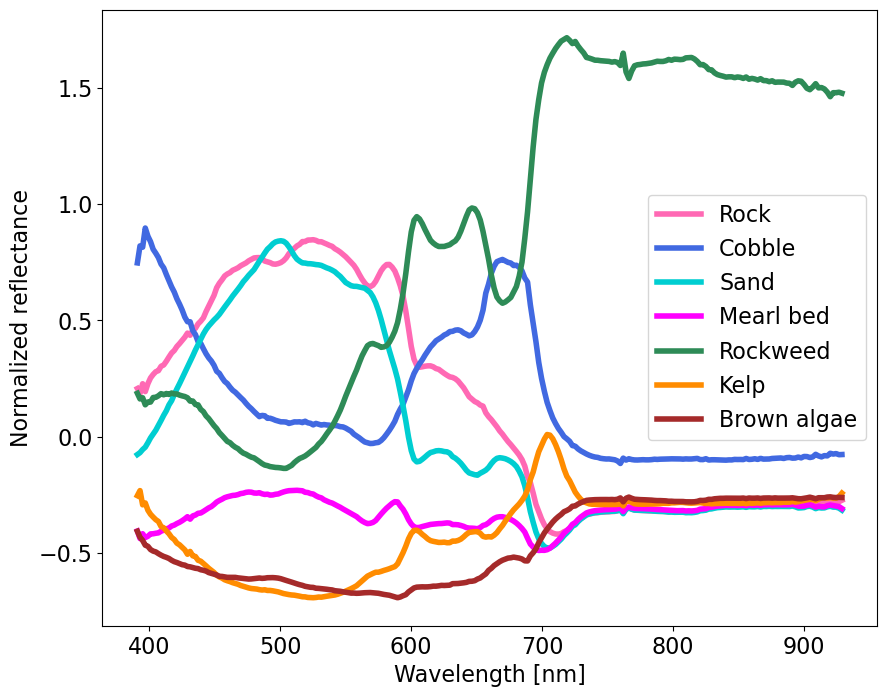

In [15]:
# Plot mean _normalized_ value for each class
mean_class_spectra = {}
plt.rcParams.update({'font.size': 16})
# plt.figure(figsize=(8,6))
plt.figure(figsize=(10,8))
for ((class_name, class_index),plot_color) in zip(class_dict.items(),custom_cmap.colors[1:]):
    class_mean = np.mean(X_norm[y_bal==class_index],axis=0)
    mean_class_spectra[class_name] = class_mean
    plt.plot(wl,class_mean,label=class_name,linewidth=4,color=plot_color)
plt.legend()
plt.xlabel('Wavelength [nm]')
plt.ylabel('Normalized reflectance')
# plt.savefig(mean_norm_spectra_fig_path,dpi=300)
plt.savefig(figures_dir / 'Vega_mean_spectra_norm.png')
plt.show()

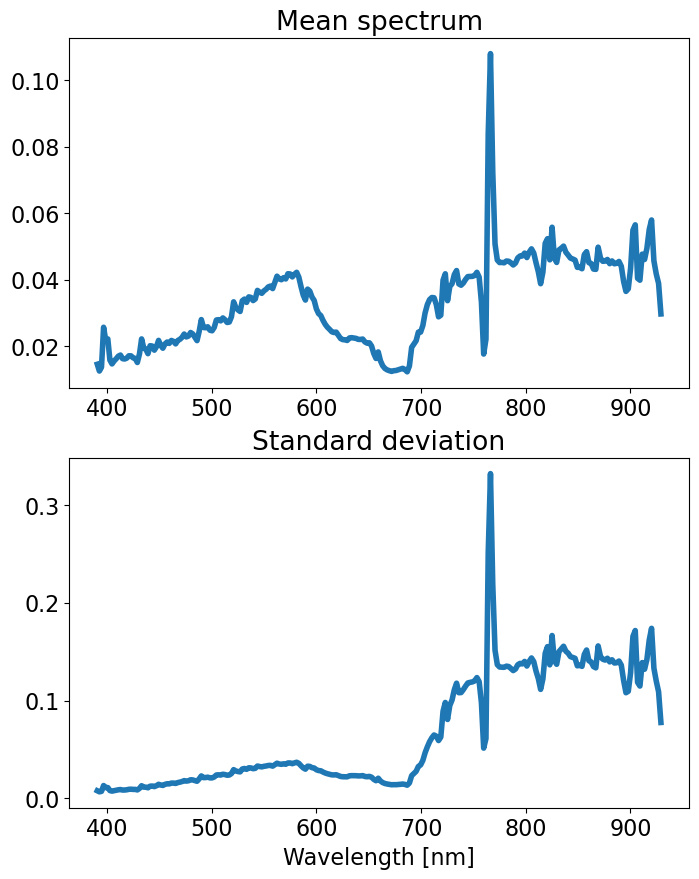

In [16]:
# Plot mean and std across all classes
plt.rcParams.update({'font.size': 16})
fig,(ax0,ax1) = plt.subplots(nrows=2,ncols=1,figsize=(8,10))

ax0.plot(wl,X_mean,linewidth=4)
ax0.set_title('Mean spectrum')
#ax0.set_xlabel('Wavelength [nm]')

ax1.plot(wl,X_std,linewidth=4)
ax1.set_title('Standard deviation')
ax1.set_xlabel('Wavelength [nm]')
plt.savefig(figures_dir / 'Vega_mean_and_std_spectrum.png')
plt.show()

In [17]:
# Demonstrate decomposition of spectrum into components
n_comp = W_pca.shape[1]
rw_comp = np.expand_dims(mean_class_spectra['Rockweed'],axis=0)@W_pca
rw_decomp_spec = np.zeros((len(wl),n_comp))
for i,comp in enumerate(rw_comp[0]):
    rw_decomp_spec[:,i] = comp*W_pca[:,i]

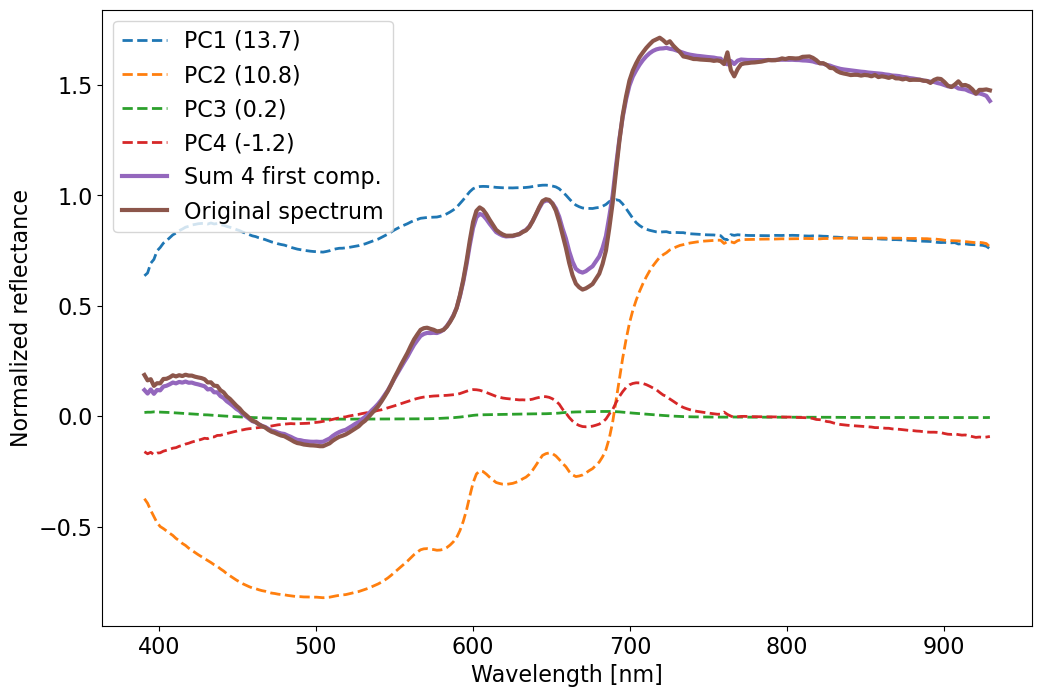

In [18]:
plt.figure(figsize=(12,8))
plt.plot(wl,rw_decomp_spec[:,0],'--',label=f'PC1 ({rw_comp[0,0]:.1f})',linewidth=2)
plt.plot(wl,rw_decomp_spec[:,1],'--',label=f'PC2 ({rw_comp[0,1]:.1f})',linewidth=2)
plt.plot(wl,rw_decomp_spec[:,2],'--',label=f'PC3 ({rw_comp[0,2]:.1f})',linewidth=2)
plt.plot(wl,rw_decomp_spec[:,3],'--',label=f'PC4 ({rw_comp[0,3]:.1f})',linewidth=2)
plt.plot(wl,np.sum(rw_decomp_spec[:,0:4],axis=1),label='Sum 4 first comp.',linewidth=3)
plt.plot(wl,mean_class_spectra['Rockweed'],label='Original spectrum',linewidth=3)
plt.xlabel('Wavelength [nm]')
plt.ylabel('Normalized reflectance')
plt.legend()
plt.savefig(figures_dir/'Mean_rockweed_spectrum_PCA_decomposition.png')
plt.show()